In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from datetime import datetime
import xgboost as xgb
import six
import pandas.util.testing as tm
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading train dataframe

In [5]:
train = pd.read_csv('../data/processed_data.csv')
train.permit = train.permit.astype(str)

### Defining X and y from dataframe and train test splitting the training data

In [6]:
X = train.drop(['id', 'status_group', 'status', 'date_recorded'], axis=1)
y = train.status
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Defining features to One Hot Encode

In [7]:
ohe_features = ['funder/installer', 'region_bins',
               'public_meeting', 'lga_coded',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 
               'payment', 'quality_group',
               'quantity', 'source_type', 'waterpoint_type/group']

### Defining continuous features for scaling

In [8]:
cont_features = ['gps_height', 'population'
                 ]

decade_features = ['2000-2010', '1990-2000', '1980-1990',
                   '2010-2020', '1970-1980', '1960-1970']

### Defining series to encode and scale, setting values that need to scaled as floats

In [9]:
X_train_ohe = X_train[ohe_features]
X_test_ohe = X_test[ohe_features]
X_train_cont = X_train[cont_features].astype(float)
X_test_cont = X_test[cont_features].astype(float)

In [10]:
X_train_index = X_train.index
X_test_index = X_test.index

### Encoding and scaling features

In [11]:
ohe = OneHotEncoder()
ss = StandardScaler()
X_train_encoded = ohe.fit_transform(X_train_ohe)
X_test_encoded = ohe.transform(X_test_ohe)
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), columns=X_train[cont_features].columns, index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), columns=X_test[cont_features].columns, index=X_test_index)

### Retrieving columns for encoded series and converting them to dataframes

In [12]:
train_columns = ohe.get_feature_names(input_features=X_train_ohe.columns)
test_columns = ohe.get_feature_names(input_features=X_test_ohe.columns)
X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

### Concatenating encoded and scaled dataframes

In [13]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)

In [14]:
X_train_all = X_train_all.join(X_train[decade_features])
X_test_all = X_test_all.join(X_test[decade_features])

In [15]:
X_train_all_3 = X_train.copy()

In [16]:
X_train_all_3

,Unnamed: 0,amount_tsh,gps_height,longitude,latitude,num_private,basin,district_code,ward,population,...,funder/installer,waterpoint_type/group,2000-2010,1990-2000,1980-1990,2010-2020,1970-1980,1960-1970,region_bins,lga_coded
24947,24947,20.0,330,38.123839,-6.087137e+00,0,Wami / Ruvu,1,Mbwewe,80,...,binned,communal standpipe,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,3,other
22630,22630,0.0,0,0.000000,-2.000000e-08,0,Lake Victoria,1,Nkungulu,0,...,dwsp/dwe,hand pump,0.061021,0.921431,0.000000,0.017548,0.000000,0.0,4,other
13789,13789,0.0,0,33.312321,-2.814100e+00,0,Lake Victoria,4,Wala,0,...,binned,hand pump,0.488395,0.076630,0.015092,0.415598,0.004286,0.0,4,other
15697,15697,0.0,1542,34.783049,-4.842093e+00,0,Internal,4,Mungumaji,23,...,central government,communal standpipe,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,4,urban
22613,22613,0.0,523,34.660944,-1.070733e+01,0,Lake Nyasa,3,Mbaha,1,...,binned,communal standpipe,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,2,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,54343,1000.0,327,36.367112,-8.774761e+00,0,Rufiji,4,Mtimbira,255,...,dhv/dwe,communal standpipe,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,3,other
38158,38158,1000.0,1743,34.531524,-9.769604e+00,0,Lake Nyasa,5,Mlangali,35,...,danida/danid,communal standpipe,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0,other
860,860,0.0,-13,38.974416,-5.420823e+00,0,Pangani,5,Pangani Mashariki,1000,...,binned,other,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,3,other
15795,15795,0.0,0,34.316586,-3.107161e+00,0,Lake Victoria,6,Sakasaka,0,...,rwssp/wedeco,hand pump,0.415797,0.374576,0.040588,0.159039,0.010000,0.0,1,other


 ## 

# Modeling

#### Logistic Regression

In [17]:
def plot_feature_importances(model):
    n_features = X_train_processed.shape[1]
    plt.figure(figsize=(12,50))
    plt.barh(range(n_features), model.feature_importances_[0], align='edge') 
    plt.yticks(np.arange(n_features), X_train_processed.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [18]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [ ]:
lreg = LogisticRegression(fit_intercept=False, multi_class='ovr',
                         random_state=42, n_jobs= -1)
lreg.fit(X_train_all, y_train)
y_pred = lreg.predict(X_test_all)
print('Testing Mean cross val score:')
print(np.mean(cross_val_score(lreg, X_test_all, y_test)))
evaluation(y_test, y_pred)

### I am going to try a Random Forest Classifier with the class weight as balanced, to use the inverse weight of the training set.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


              precision    recall  f1-score   support

           0       0.81      0.76      0.78      5678
           1       0.35      0.45      0.39      1074
           2       0.81      0.82      0.81      8098

    accuracy                           0.77     14850
   macro avg       0.66      0.67      0.66     14850
weighted avg       0.78      0.77      0.77     14850

Accurancy:  0.7663973063973064


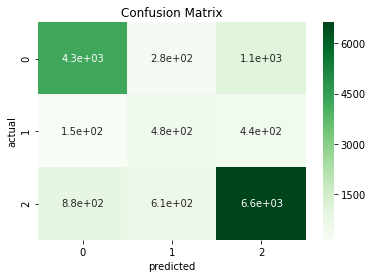

In [20]:
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', 
                           random_state=42, n_jobs= -1)
rf.fit(X_train_all, y_train)
np.mean(cross_val_score(rf, X_test_all, y_test, scoring='f1_macro',
                       n_jobs= -1, verbose=2))
evaluation(y_test, rf.predict(X_test_all))

#### Defining parameter grid for Random Forest Classifier

In [25]:
param_grid = {'n_estimators': [300, 500, 800, 1200],
              'max_depth':[6, 15, 25, 50],
              'min_samples_split': [2, 5, 10, 15],
              'min_samples_leaf': [1, 2, 5, 10]}

## Warning!
#### This block of code takes a little over 7 hours to run

In [ ]:
rf2 = RandomForestClassifier(class_weight='balanced_subsample', random_state=42,
                             n_jobs= -1)
estimator = GridSearchCV(estimator=rf2, param_grid=param_grid, scoring='f1_macro', cv=3,
                        n_jobs = -1)
estimator.fit(X_train_all, y_train)
y_pred = estimator.predict(X_test_all)


In [27]:
estimator.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1200}

In [29]:
estimator.score(X_train_all, y_train)

0.7948632776995943

#### Fitting a new random forest classifier with the best parameters defined above

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      5678
           1       0.33      0.59      0.42      1074
           2       0.82      0.79      0.81      8098

    accuracy                           0.76     14850
   macro avg       0.66      0.71      0.67     14850
weighted avg       0.79      0.76      0.77     14850

Accurancy:  0.7593265993265993


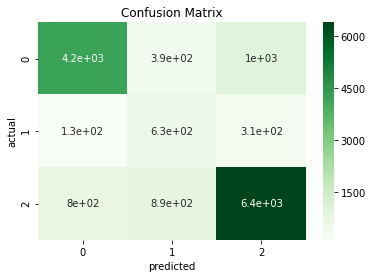

In [45]:
rf3 = RandomForestClassifier(max_depth=25, min_samples_leaf=1, 
                             class_weight='balanced_subsample', random_state=42,
                             min_samples_split=10, n_jobs= -1, n_estimators=1200)
rf3.fit(X_train_all, y_train)
y_pred = rf3.predict(X_test_all)
evaluation(y_test, y_pred)


#### I am going to try running a grid search with the xgboost classifier and compare the results to the random forest classifier

#### Instantiating the gradient boosing classifier

In [33]:
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train_all, y_train)
training_preds = clf.predict(X_train_all)
y_preds = clf.predict(X_test_all)


#### Defining parameter grid for xgboost classifier

In [38]:

param_grid3 = {
    "learning_rate": [0.1],
    'max_depth': [6, 8, 15],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [ 30, 100, 250, 600],
    'verbosity': [3]
}

#### Instantiating the grid search cv with the gradient boost classifier as the estimator, fitting it to the training split, and scoring on the test split.

In [41]:
grid_clf = GridSearchCV(clf, param_grid3, scoring='f1_macro', cv=3, n_jobs= -1)
start_time = timer(None)
grid_clf.fit(X_train_all, y_train)
timer(start_time)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_all)
val_preds = grid_clf.predict(X_test_all)

[11:47:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=15
[11:47:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=15
[11:47:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=15
[11:47:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=15
[11:47:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=15
[11:47:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 0 pruned nodes, max_depth=15
[11:47:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=15
[11:47:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=15
[11:47:28] INFO: src/tree/updater_prune.

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      5678
           1       0.50      0.32      0.39      1074
           2       0.79      0.87      0.83      8098

    accuracy                           0.79     14850
   macro avg       0.70      0.65      0.67     14850
weighted avg       0.78      0.79      0.78     14850

Accurancy:  0.7877441077441077


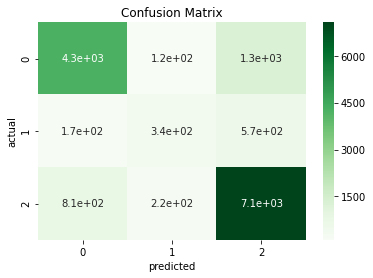

In [43]:
evaluation(y_test, val_preds)

In [44]:
grid_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 10,
 'n_estimators': 600,
 'subsample': 0.7,
 'verbosity': 3}

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      5678
           1       0.50      0.32      0.39      1074
           2       0.79      0.87      0.83      8098

    accuracy                           0.79     14850
   macro avg       0.70      0.65      0.67     14850
weighted avg       0.78      0.79      0.78     14850

Accurancy:  0.7877441077441077


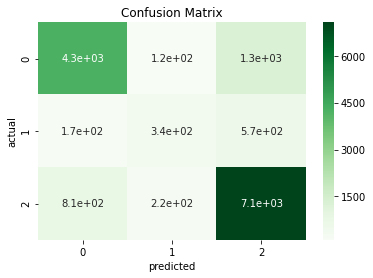

In [48]:
test_pred = grid_clf.best_estimator_.predict(X_test_all)
evaluation(y_test, test_pred)

## SMOTE
#### Oversampling the minority class

In [19]:
train = pd.read_csv('../data/processed_data.csv')
train.permit = train.permit.astype(str)

In [20]:
ohe_features = ['funder/installer', 'region_bins',
               'public_meeting', 'lga_coded',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 
               'payment', 'quality_group',
               'quantity', 'source_type', 'waterpoint_type/group']

In [21]:
cont_features = ['gps_height', 'population'
                 ]

decade_features = ['2000-2010', '1990-2000', '1980-1990',
                   '2010-2020', '1970-1980', '1960-1970']

In [22]:
train_ohe = train[ohe_features]
train_cont = train[cont_features].astype(float)
train_index = train.index

ohe2 = OneHotEncoder()
ss2 = StandardScaler()
train_encoded = ohe2.fit_transform(train_ohe)
train_scaled = pd.DataFrame(ss2.fit_transform(train_cont), columns=train[cont_features].columns, index=train_index)
train_columns = ohe2.get_feature_names(input_features=train_ohe.columns)
train_processed = pd.DataFrame(train_encoded.todense(), columns=train_columns, index=train_index)
train_all = pd.concat([train_scaled, train_processed], axis=1)
train_all = train_all.join(train[decade_features])

In [23]:
train_all['status'] = train['status']

In [24]:
X_smote = train_all.drop(['status'], axis=1)
y_smote = train_all.status
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_res, y_res = smote.fit_sample(X_smote, y_smote)

In [25]:
X_res.shape

(87342, 144)

In [26]:
y_res.value_counts()

2    32259
1    32259
0    22824
Name: status, dtype: int64

[16:00:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 0 pruned nodes, max_depth=15
[16:00:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 902 extra nodes, 0 pruned nodes, max_depth=15
[16:00:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=15
[16:00:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=15
[16:00:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 0 pruned nodes, max_depth=15
[16:00:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=15
[16:01:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=15
[16:01:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=15
[16:01:05] INFO: src/tree/updater_prune

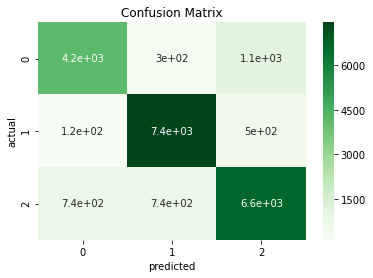

In [94]:
X_t, X_val, y_t, y_val = train_test_split(X_res, y_res, random_state=42)
grid_clf.best_estimator_.fit(X_t, y_t)
y_pred = grid_clf.best_estimator_.predict(X_val)
evaluation(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5643
           1       0.88      0.92      0.90      8068
           2       0.80      0.82      0.81      8125

    accuracy                           0.84     21836
   macro avg       0.84      0.83      0.83     21836
weighted avg       0.84      0.84      0.84     21836

Accurancy:  0.8379281919765524


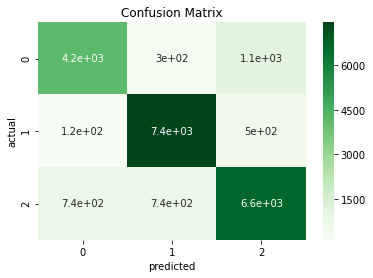

In [96]:
rf3.fit(X_t, y_t)
rain_pred = rf3.predict(X_val)


              precision    recall  f1-score   support

           0       0.82      0.76      0.79      5643
           1       0.86      0.92      0.89      8068
           2       0.81      0.79      0.80      8125

    accuracy                           0.83     21836
   macro avg       0.83      0.83      0.83     21836
weighted avg       0.83      0.83      0.83     21836

Accurancy:  0.8326158637113025


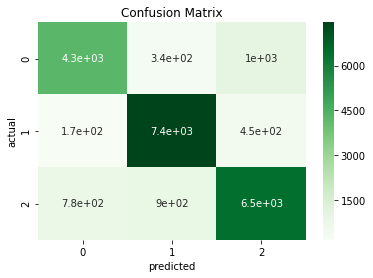

In [97]:
evaluation(y_test, rf3.predict(X_test_all))

best xgboost parameters
{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1200}

In [131]:
param_grid4 = {'n_estimators': [1200],
              'max_depth':[25],
              'min_samples_split': [10],
              'min_samples_leaf': [1]}

Best Random Forest parameters
{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1200}

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      5643
           1       0.86      0.92      0.89      8068
           2       0.81      0.79      0.80      8125

    accuracy                           0.83     21836
   macro avg       0.83      0.83      0.83     21836
weighted avg       0.83      0.83      0.83     21836

Accurancy:  0.8326158637113025


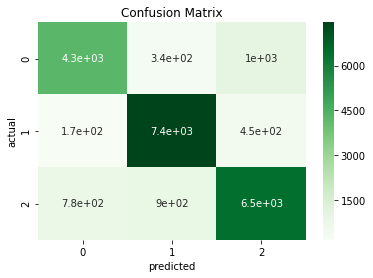


 Time taken: 0 hours 2 minutes and 35.09 seconds.


In [135]:
rf4 = RandomForestClassifier(random_state=42, max_depth=25, min_samples_split=10,
                             n_jobs= -1, n_estimators=1200, class_weight='balanced_subsample')
start_time = timer(None)
rf4.fit(X_t, y_t)
y_pred = rf4.predict(X_val)
evaluation(y_val, y_pred)
timer(start_time)

### predicting on the train test split data that was not resampled with the parameters from above.

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5678
           1       0.42      0.78      0.55      1074
           2       0.88      0.82      0.85      8098

    accuracy                           0.81     14850
   macro avg       0.72      0.80      0.74     14850
weighted avg       0.84      0.81      0.82     14850

Accurancy:  0.8145454545454546


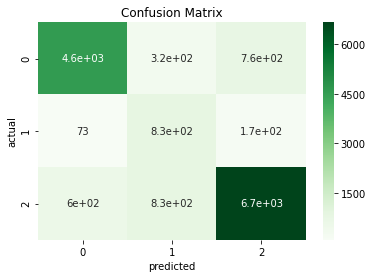

In [138]:
test_pred_rf4 = rf4.predict(X_test_all)
evaluation(y_test, test_pred_rf4)

### xgboost classifier with best params except n_estimators changed from 600 to 800, from first run on smote resampled x and y

In [134]:
xg_optimal_params = {'learning_rate': [0.01],
                    'max_depth': [15],
                    'min_child_weight': [10],
                    'n_estimators': [800],
                    'subsample': [0.7],
                    'verbosity': [3]}

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      5643
           1       0.86      0.92      0.89      8068
           2       0.79      0.83      0.81      8125

    accuracy                           0.83     21836
   macro avg       0.83      0.82      0.82     21836
weighted avg       0.83      0.83      0.83     21836

Accurancy:  0.8306466385784942


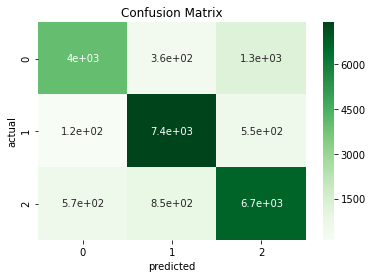


 Time taken: 1 hours 7 minutes and 53.18 seconds.


In [137]:
xgb2 = xgb.XGBClassifier(learning_rate=0.01, max_depth=15, min_child_weight=10,
                        n_estimators=800, subsample=0.7)
start_time = timer(None)
xgb2.fit(X_t, y_t)
y_pred = xgb2.predict(X_val)
evaluation(y_val, y_pred)
timer(start_time)

### Trying another xgboost classifier with minor tweaks to the parameters and fitting to the smote resampled x and y

In [38]:
start_time = timer(None)
timer(start_time)


 Time taken: 0 hours 0 minutes and 0.0 seconds.


In [42]:
X_t, X_val, y_t, y_val = train_test_split(X_res, y_res, random_state=42)

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      5643
           1       0.87      0.92      0.89      8068
           2       0.79      0.83      0.81      8125

    accuracy                           0.83     21836
   macro avg       0.84      0.82      0.83     21836
weighted avg       0.83      0.83      0.83     21836

Accurancy:  0.8342187213775417


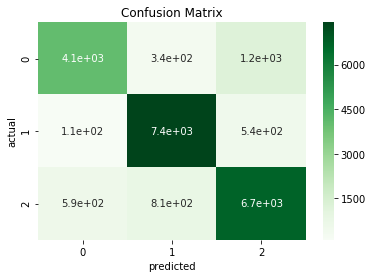


 Time taken: 1 hours 30 minutes and 23.51 seconds.


In [43]:
xgb3 = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=15,
                        min_child_weight=10, subsample=0.7, random_state=42)
start_time = timer(None)
xgb3.fit(X_t, y_t)
y_pred = xgb3.predict(X_val)
evaluation(y_val, y_pred)
timer(start_time)

#### Predicting on the test data that was not resampled with smote

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      5678
           1       0.36      0.75      0.49      1074
           2       0.85      0.82      0.84      8098

    accuracy                           0.79     14850
   macro avg       0.70      0.77      0.71     14850
weighted avg       0.83      0.79      0.80     14850

Accurancy:  0.7907744107744108


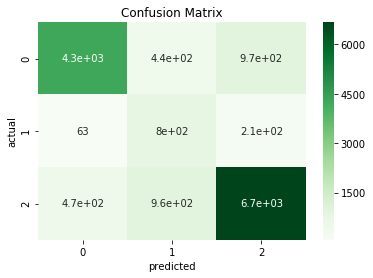

In [44]:
test_pred = xgb3.predict(X_test_all)
evaluation(y_test, test_pred)

##### That the recall and accuracy are still lower than those of the Random Forest Classifier. Looks like this may be our best classifier

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      5643
           1       0.86      0.92      0.89      8068
           2       0.81      0.80      0.81      8125

    accuracy                           0.83     21836
   macro avg       0.83      0.83      0.83     21836
weighted avg       0.83      0.83      0.83     21836

Accurancy:  0.8336691701776883


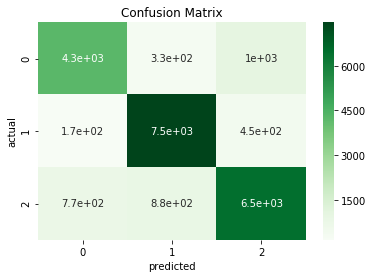

None

 Time taken: 0 hours 2 minutes and 49.65 seconds.
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5678
           1       0.43      0.78      0.55      1074
           2       0.88      0.83      0.86      8098

    accuracy                           0.82     14850
   macro avg       0.73      0.81      0.75     14850
weighted avg       0.85      0.82      0.83     14850

Accurancy:  0.8204040404040404


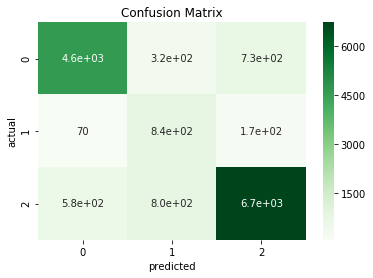

None


In [45]:
rf5 = RandomForestClassifier(random_state=42, max_depth=25, min_samples_split=8,
                             n_jobs= -1, n_estimators=1500, class_weight='balanced_subsample')
start_time = timer(None)
rf5.fit(X_t, y_t)
y_pred = rf5.predict(X_val)
print(evaluation(y_val, y_pred))
timer(start_time)
print(evaluation(y_test, rf5.predict(X_test_all)))

In [59]:
print('{}'.format(str(train)), classification_report(y, y_hat))

NameError: name 'y_hat' is not defined